In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [4]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator


import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [6]:
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == "Astronomy & Astrophysics"]
data_grouped_by_year_label = None

In [7]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words
1212,1212,Astronomy & Astrophysics,1900,"[crossley reflector lick obsertvatory, crossle...","[calculation elliptic elements system cygni , ...",calculation elliptic elements system cygni ph...,calculation elliptic elements system cygni phy...
1213,1213,Astronomy & Astrophysics,1901,"[accuracy photographic measures second note ,...","[form interferometer , sixty four variable sta...",form interferometer sixty four variable stars...,form interferometer sixty four variable stars ...
1214,1214,Astronomy & Astrophysics,1902,"[miscellaneous results , miscellaneous results...",[researches spectra metals spectrum molybdenu...,researches spectra metals spectrum molybdenum...,researches spectra metals spectrum molybdenum ...
1215,1215,Astronomy & Astrophysics,1903,"[cape double star results 1903 , cape double ...",[spectrographic observations standard velocity...,spectrographic observations standard velocity ...,spectrographic observations standard velocity ...
1216,1216,Astronomy & Astrophysics,1904,[magnetic disturbances recorded royal observat...,"[ninth satellite saturn , revised elements cyg...",ninth satellite saturn revised elements cygni...,ninth satellite saturn revised elements cygni ...


In [8]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

In [9]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

In [10]:
vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [11]:
vectorized_wordarray.shape

(117, 47379)

In [12]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))

Progress: 100%|██████████| 117/117 [00:00<00:00, 61711.97it/s]


In [13]:
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:00<00:00, 389.38it/s]


In [14]:
count_matrix = vectorized_words.toarray()

In [15]:
count_matrix[:4,100:120]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],
      dtype=int64)

__Distribution of word counts in a year__

In [16]:
uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

In [17]:
idx = 0
print(len(counts[idx]))
print(len(uniques[idx]))

19
19


__Frequency Variations__

Words which have a frequency of 20 in year Y<sub>t</sub>. How much do they normally vary in years Y<sub>t+1</sub>, t<sub>t+2</sub> etc.

In [18]:
word_freq_variations = []
avg_variations_for_freq = []

for index in range(vectorized_wordarray.shape[0] - 1):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
#         if index == 49 and uniq == 12:
#             import ipdb
#             ipdb.set_trace()
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

In [19]:
#variations
#array([ 3, 12], dtype=int64)

#np.mean(variations)
#7.5

In [20]:
avg_variations_for_freq[idx]

{0: 0.006,
 1: -0.64,
 2: -1.05,
 3: -1.158,
 4: -1.739,
 5: -0.5,
 6: -1.2,
 7: -5.667,
 8: -5.0,
 9: -4.5,
 10: 4.5,
 11: -0.333,
 12: -5.0,
 13: -5.0,
 15: 6.0,
 16: -11.0,
 18: -6.0,
 31: -10.0,
 34: -9.0}

In [21]:
# what are the frequencies of words in 1900
print("Average change in freq of a word appearing `index` times in 1900 ", avg_variations_for_freq[0])

Average change in freq of a word appearing `index` times in 1900  {0: 0.006, 1: -0.64, 2: -1.05, 3: -1.158, 4: -1.739, 5: -0.5, 6: -1.2, 7: -5.667, 8: -5.0, 9: -4.5, 10: 4.5, 11: -0.333, 12: -5.0, 13: -5.0, 15: 6.0, 16: -11.0, 18: -6.0, 31: -10.0, 34: -9.0}


In [22]:
# check if the word with frequency is changing at more than an average frequency
words_with_high_rate_of_change = []

word_indices = []
word_indices_below_avg = []

for year_index in tqdm(range(1, vectorized_wordarray.shape[0])):
    
    prev_year = vectorized_wordarray[year_index -1]
    current_year = vectorized_wordarray[year_index]
    
    avg_change_rate_for_year = avg_variations_for_freq[year_index - 1]
    
    word_indices_above_average_for_year = {}
    word_indices_below_average_for_year = {}
    
    #for freq in range(len(avg_variations_for_freq[year_index])):
    for count, mean_variation in avg_change_rate_for_year.items():
        
        try:
            #avg_freq_for_words_with_similar_freq_in_current_year = avg_change_rate_for_year[freq]
        
            # indices in tmp_ where avg_change_rate_for_year
            indices1 = np.where(prev_year == count)[0]            
            indices2 = np.where(current_year > mean_variation)[0]
            indices3 = np.where(current_year < mean_variation)[0]
            
            above_average_freq_indices = [index for index in indices1 if index in indices2]
            below_average_freq_indices = [index for index in indices1 if index in indices3]
            
            word_indices_above_average_for_year[count] = above_average_freq_indices
            word_indices_below_average_for_year[count] = below_average_freq_indices
            
        except:
            
            import ipdb
            ipdb.set_trace()
        
    word_indices.append(word_indices_above_average_for_year) 
    word_indices_below_avg.append(word_indices_below_average_for_year)

100%|██████████| 116/116 [02:30<00:00,  1.37s/it]


__Consider the words appearing 15 times in 1950__

In [23]:
year_idx = 49
print(word_indices[year_idx].keys())
print(word_indices[year_idx][12])
#print(word_indices_below_avg[year_idx][1])
print(vectorized_wordarray[:,index:index+1][49])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20, 37])
[39017, 39469]
[0]


In [24]:
print(words[39017])

w = "deuteron"
vectorizer.vocabulary_[w]

solar


10331

__Just look at the counts instead of above average growth rate__

In [25]:
def check_freq_increasing(index, start_year, buffer=3):
    
    begin_index = (start_year % 100) - 1
    # [begin_index:begin_index+4]
    tmp = vectorized_wordarray[:,index:index+1][begin_index:]
    return tmp.reshape(-1,)   
    

index = 39017   
start = 1967
x = list(range(start,2018))
y = check_freq_increasing(index, start)    

In [26]:
len(y)

51

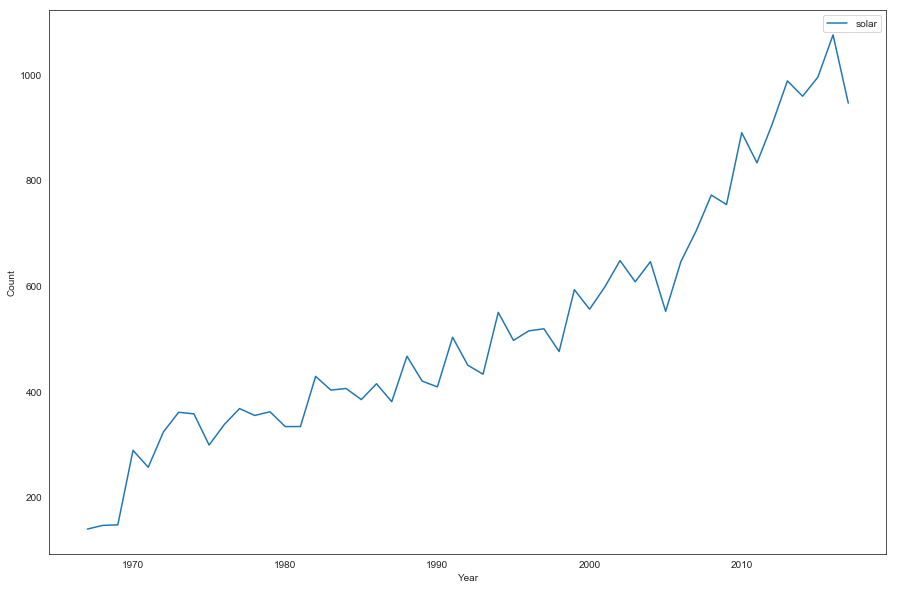

In [27]:
f = plt.figure(figsize=(15,10))

ax = f.add_subplot(111)

ax.plot(x,y, label=words[index])
ax.set_xlabel("Year")
ax.set_ylabel("Count")

ax.legend()

In [28]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
1212,1212,Astronomy & Astrophysics,1900,"[crossley reflector lick obsertvatory, crossle...","[calculation elliptic elements system cygni , ...",calculation elliptic elements system cygni ph...,calculation elliptic elements system cygni phy...,356,1040
1213,1213,Astronomy & Astrophysics,1901,"[accuracy photographic measures second note ,...","[form interferometer , sixty four variable sta...",form interferometer sixty four variable stars...,form interferometer sixty four variable stars ...,296,843
1214,1214,Astronomy & Astrophysics,1902,"[miscellaneous results , miscellaneous results...",[researches spectra metals spectrum molybdenu...,researches spectra metals spectrum molybdenum...,researches spectra metals spectrum molybdenum ...,304,950
1215,1215,Astronomy & Astrophysics,1903,"[cape double star results 1903 , cape double ...",[spectrographic observations standard velocity...,spectrographic observations standard velocity ...,spectrographic observations standard velocity ...,330,990
1216,1216,Astronomy & Astrophysics,1904,[magnetic disturbances recorded royal observat...,"[ninth satellite saturn , revised elements cyg...",ninth satellite saturn revised elements cygni...,ninth satellite saturn revised elements cygni ...,348,985


In [34]:
w

'deuteron'

In [48]:
def popularity(word):
    
    word_ = " " + word + " "
   
    def word_in_sentence(sentence):
        return word_ in sentence
    
    data = input_.copy(deep=True)
    data["titles_with_word"] = data["cleaned_titles"].apply(lambda x: len(list(filter(word_in_sentence, x))))
    data["count_of_words"] = data["title_words"].apply(lambda x: x.count(word_))
    data["normalized_title_count"] = data.apply(lambda x: round(x["titles_with_word"]/x["number_of_pubs"], 3), axis=1)                                                                   
   
    return data
    
foo = popularity("solar")   
word2 = popularity(w)
word3 = popularity("dust")
word4 = popularity("lacertae")
word5 = popularity("spectrum")
word6 = popularity("radio")


In [44]:
foo.iloc[49:55]

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count,titles_with_word,count_of_words,normalized_title_count
1261,1261,Astronomy & Astrophysics,1949,"[cosmological problem, cosmological problem, c...","[structure stars non uniform composition, self...",structure stars non uniform composition self c...,structure stars non uniform composition self c...,494,1322,9,12,0.018
1262,1262,Astronomy & Astrophysics,1950,"[spectroscopic binary delta orionis, spectrosc...","[observations double stars, spectroscopic comp...",observations double stars spectroscopic compar...,observations double stars spectroscopic compar...,524,1404,12,15,0.023
1263,1263,Astronomy & Astrophysics,1951,"[ veranderungen spektrum orionis, veranderung...",[ uber induktionsfluss durch sonnenfleckengrup...,uber induktionsfluss durch sonnenfleckengrupp...,uber induktionsfluss durch sonnenfleckengruppe...,520,1388,6,7,0.012
1264,1264,Astronomy & Astrophysics,1952,[semiregular variable stars tauri related clas...,"[note color magnitude diagram messier 3, probl...",note color magnitude diagram messier 3 problem...,note color magnitude diagram messier problems ...,640,1623,9,12,0.014
1265,1265,Astronomy & Astrophysics,1953,"[outer atmospheres some stars, outer atmospher...",[parallax orbital motion multiple system omega...,parallax orbital motion multiple system omega ...,parallax orbital motion multiple system omega ...,524,1402,14,19,0.027
1266,1266,Astronomy & Astrophysics,1954,"[secular accelerations phobos jupiter v, secul...","[colors bright stars, revised analysis solar s...",colors bright stars revised analysis solar spe...,colors bright stars revised analysis solar spe...,654,1752,18,25,0.028


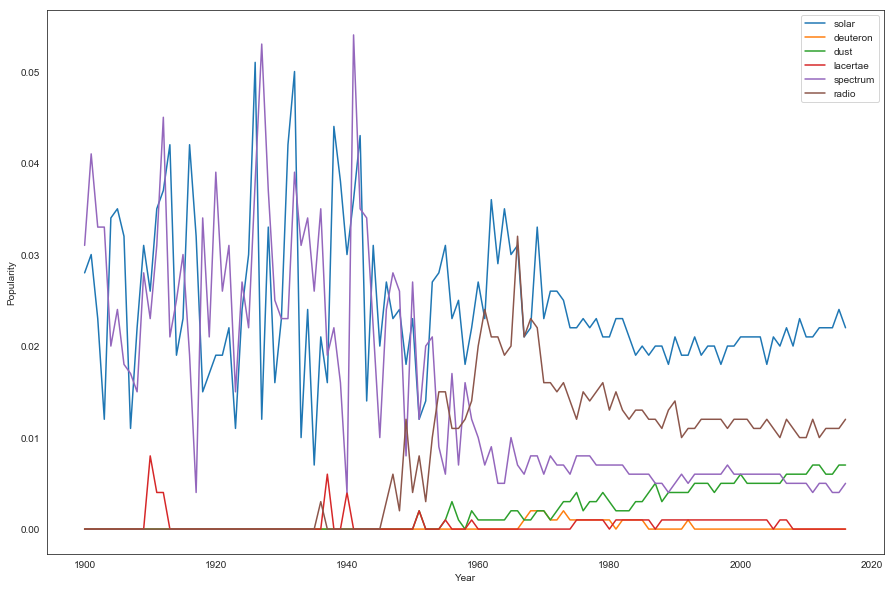

In [49]:
f = plt.figure(figsize=(15,10))

ax = f.add_subplot(111)

ax.plot(foo["PubYear"],foo["normalized_title_count"], label=words[39017])
ax.plot(word2["PubYear"],word2["normalized_title_count"], label=w)
ax.plot(word3["PubYear"],word3["normalized_title_count"], label="dust")
ax.plot(word4["PubYear"],word4["normalized_title_count"], label="lacertae")
ax.plot(word5["PubYear"],word5["normalized_title_count"], label="spectrum")
ax.plot(word6["PubYear"],word6["normalized_title_count"], label="radio")


ax.set_xlabel("Year")
ax.set_ylabel("Popularity")

ax.legend()